# Dependencies and settings

In [12]:
# models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, \
                            precision_score, confusion_matrix, f1_score, roc_curve

# other
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import ipywidgets as widgets
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = [25,17]
display(HTML("<style>.container { width:60% !important; }</style>"))
display(HTML("<style> div.text_cell { width:70% !important; }</style>"))

# Data loading & preprocessing

In [2]:
df = pd.read_csv("data/heloc_dataset_v1.csv")
df = df.loc[(df == -9).sum(axis=1)==0, :]
df = df.reset_index(drop=True)
df.loc[:,'is_MSinceMostRecentDelq_minus_7'] = df.MSinceMostRecentDelq == -7
df.loc[:,'is_MSinceMostRecentInqexcl7days_minus_8'] = df.MSinceMostRecentInqexcl7days == -8

In [3]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,is_MSinceMostRecentDelq_minus_7,is_MSinceMostRecentInqexcl7days_minus_8
0,Bad,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69,False,False
1,Bad,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0,True,False
2,Bad,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86,True,False
3,Bad,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91,False,False
4,Bad,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80,True,False


# Function definitions

In [4]:
def make_classifier(X_train, y_train, classifier_class=RandomForestClassifier, params={}):
    """
        Creates classifier with given params
        returns: classifier
    """
    classifier = classifier_class(**params)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifiers(X_test, y_test, classifiers):
    """
        Evaluates given classifiers
        returns: pandas.DataFrame containing calculated model' quality metrics
    """
    scores_df = pd.DataFrame()
    for classifier_name, classifier in classifiers.items():
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        scores = {
            "accuracy": accuracy_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        scores_df_row = pd.DataFrame(scores, index=[classifier_name])
        scores_df = pd.concat([scores_df, scores_df_row])
    return scores_df

def plot_roc_curve(X_test, y_test, classifiers):
    """
        Plots ROC curve
    """
    plt.plot([0,1],[0,1], c='k')
    for classifier_name, classifier in classifiers.items():
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=classifier_name)
    plt.xlabel('fpr',fontsize=24)
    plt.ylabel('tpr',fontsize=24)
    plt.title('ROC curve for trained classifiers', fontsize=36)
    plt.legend(loc=4, fontsize='xx-large')
    plt.show()
    
def highlight_max(s):
    '''
        Highlights the maximum in a Series lime
    '''
    is_max = s == s.max()
    return ['background-color: lime' if v else '' for v in is_max]

def partial_dependency_plot_for_classifiers(X_test, y_test, classifiers, dependent_feature_name, possible_values):
    X_test_copy = X_test.copy()
    y = {}
    for classifier_name in classifiers.keys():
        y[classifier_name] = []
    for value in possible_values:
        X_test_copy.loc[:,dependent_feature_name] = value
        for classifier_name, classifier in classifiers.items():
            y_pred = classifier.predict(X_test_copy)
            y[classifier_name].append(accuracy_score(y_test, y_pred))
    for classifier_name in classifiers.keys():
        plt.plot(possible_values, y[classifier_name], label=classifier_name, marker='.', markersize=5)
    plt.ylim([0.5,1])
    plt.ylabel('Accuracy', fontsize=24)
    plt.xlabel(dependent_feature_name, fontsize=24)
    plt.title(f'{dependent_feature_name} partial dependency plot', fontsize=36)
    plt.legend(fontsize=30)
    plt.show()

# Classifiers

In [5]:
X, y =  df.drop(["RiskPerformance"], axis=1), pd.Categorical(df.RiskPerformance, categories=["Bad", "Good"]).codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
classifiers = { }

# Regresja logistyczna + regularyzacja
classifiers['LogisticRegression'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                                   ('log_reg', LogisticRegression())]})
# K-najblizszych sasiadow
classifiers['KNearestNeighbors'] = make_classifier(X_train, y_train, classifier_class=KNeighborsClassifier, params={'n_neighbors': 7})

# Lasy losowe
classifiers['RandomForest'] = make_classifier(X_train, y_train, classifier_class=RandomForestClassifier, params={'n_estimators':25})

# Gradient boosting
classifiers['GradientBoosting'] = make_classifier(X_train, y_train, classifier_class=GradientBoostingClassifier)

# RBF SVC
classifiers['RBFSVC'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                    ('svc', SVC(probability=True))]})

# Linear SVC
classifiers['LinearSVC'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                    ('svc', SVC(kernel='linear', probability=True))]})

# Ada boosting na drzewach decyzyjnych
classifiers['AdaBoostingOnTrees'] = make_classifier(X_train, y_train, classifier_class=AdaBoostClassifier)

# Ada boosting na regresji logistycznej
classifiers['AdaBoostingOnLogReg'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                                   ('ada_boost', AdaBoostClassifier(base_estimator=LogisticRegression()))]})

# Gaussian process
classifiers['GaussianProcess'] = make_classifier(X_train, y_train, classifier_class=GaussianProcessClassifier)

# Naive Bayes
classifiers['NaiveBayes'] = make_classifier(X_train, y_train, classifier_class=GaussianNB)

# Evaluation

In [6]:
evaluate_classifiers(X_test, y_test, classifiers).style.apply(highlight_max)

,accuracy,auc,precision,recall,f1
LogisticRegression,0.735428,0.805827,0.739802,0.701149,0.719957
KNearestNeighbors,0.686771,0.724746,0.675284,0.682341,0.678794
RandomForest,0.719209,0.793989,0.722161,0.684431,0.70279
GradientBoosting,0.735935,0.809671,0.736957,0.708464,0.722429
RBFSVC,0.734921,0.803783,0.748853,0.682341,0.714051
LinearSVC,0.736442,0.806863,0.741436,0.701149,0.72073
AdaBoostingOnTrees,0.733401,0.809422,0.728042,0.718913,0.723449
AdaBoostingOnLogReg,0.735935,0.805115,0.73956,0.703239,0.720943
GaussianProcess,0.6148,0.500492,0.613088,0.557994,0.584245
NaiveBayes,0.724278,0.785177,0.703448,0.746082,0.724138


# Plotting ROC curve

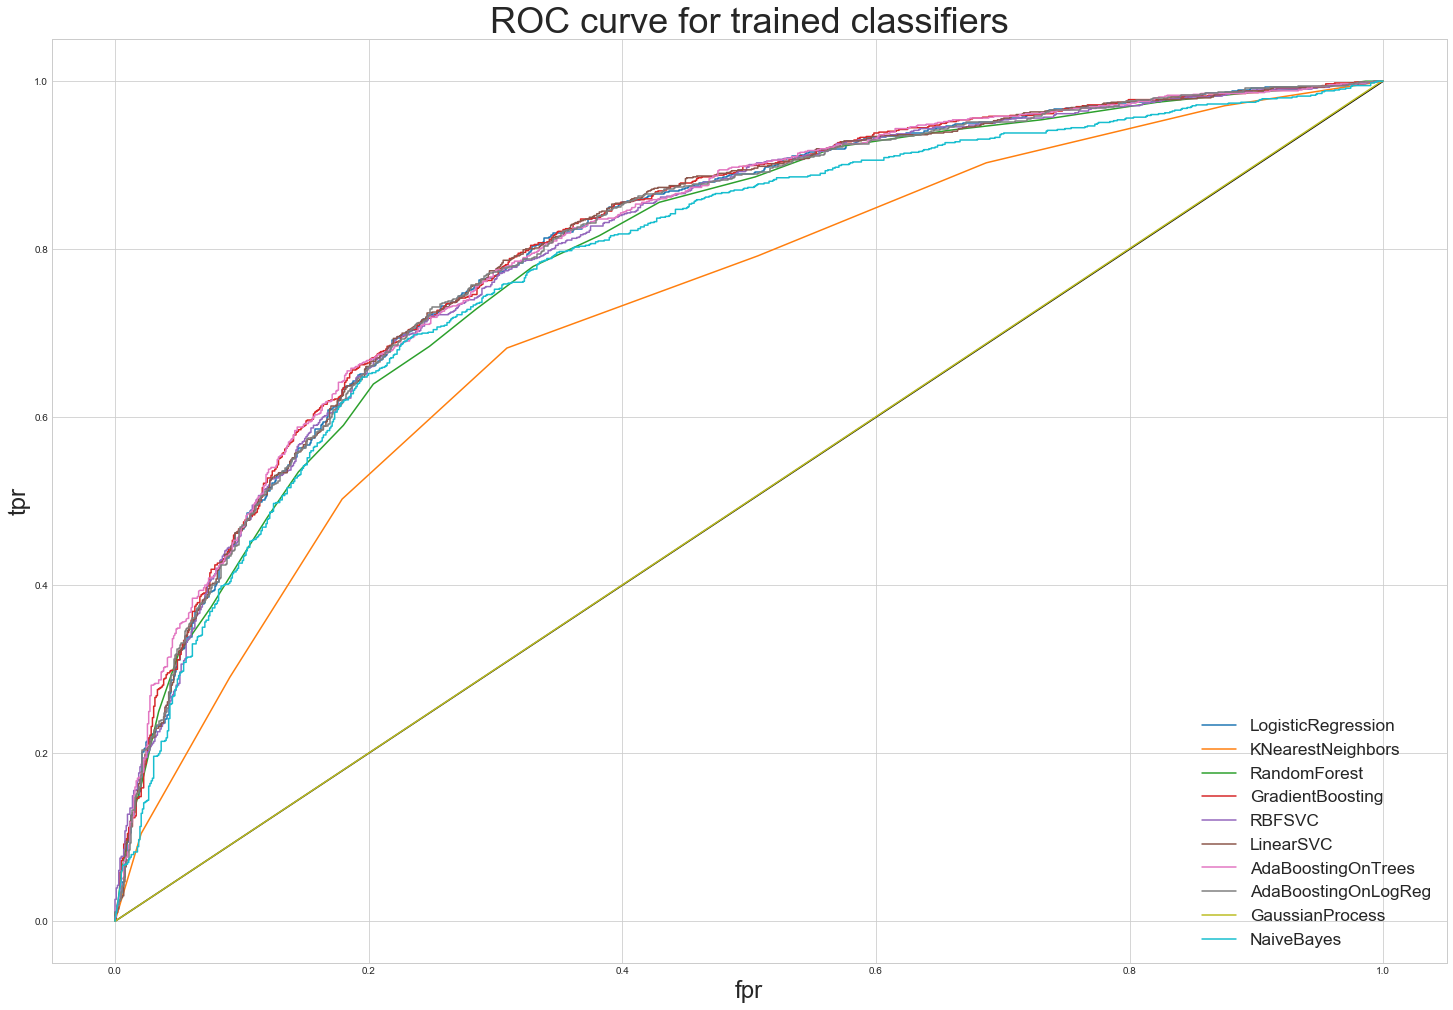

In [10]:
plot_roc_curve(X_test, y_test, classifiers)

# Partial dependency plots

Po utworzeniu podstawowych modeli postanowiliśmy sprawdzić ich czułość na zmiany poszczególnych zmiennych. W naszym zbiorze większość danych to dane ilościowe, dzięki czemu byliśmy w stanie zwizualizować ich wpływ przy użyciu *partial dependency plots*:

In [11]:
selector = widgets.Select(
    options=X_train.columns,
    rows=10,
    description='Feature:',
    disabled=False
)

widgets.interact(lambda feature_name : partial_dependency_plot_for_classifiers(X_test,
                                        y_test,
                                        {name: classifiers[name] for name in ['LogisticRegression',
                                                                              'RandomForest',
                                                                              'GradientBoosting',
                                                                              'KNearestNeighbors']},
                                        feature_name,
                                        np.sort(X.loc[:,feature_name].unique())), feature_name=selector)
print()

interactive(children=(Select(description='Feature:', options=('ExternalRiskEstimate', 'MSinceOldestTradeOpen',…

# Hyperparametric tuning of Gradient Boosting

In [20]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = [{'loss': ['deviance','exponential'],
              'n_estimators': [500,1000,2000,5000,10000],
              'min_samples_split': [2,3],
              'min_samples_leaf': [1,2],
              'max_depth': np.arange(3,11,2)}]

gs = GridSearchCV(estimator=gb,param_grid=param_grid,cv=2,scoring='roc_auc',n_jobs=-2)

gs.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid=[{'loss': ['deviance', 'exponential'], 'n_estimators': [500, 1000, 2000, 5000, 10000], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2], 'max_depth': array([3, 5, 7, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
gs.best_score_

0.7917236859460528

In [22]:
gs.best_params_

{'loss': 'exponential',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}